# Load numpy and all other packages required

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


# Parameters

In [2]:
NoParticles = 400;       # Number of particles in the system
xsize = 1024;            # Pixel size of the binary image in the x direction, no should be even
ysize = 1024;            # Pixel size of the binary image in the y direction, no should be even  
Binaryframewidth = 100;  # Frame around binary image without any cells
dt = 2;                  # Time step of the displacement
Particleradius = 5;      # Radius of the particles in the binary image before Gaussian Blurring and noise addition
Gaussianwidth = 3;       # Standard deviation for Gaussian kernel in px
Noise_std = 70;          # Standard deviation of the noise

# Create particles
Here, we generate N particles randomly and homogeneously distributed in the 2d space.

In [3]:
from numpy import random
Particles_Pos = random.rand(NoParticles,2)
Particles_Pos[:, 0] = (Particles_Pos[:,0] -0.5) * (xsize - 200) 
Particles_Pos[:, 1] = (Particles_Pos[:,1] -0.5) * (ysize - 200)

# Generate velocity field
Right now I use a field that attracts the cells to the point (0,0) with the potential V ~ x^2 + y^2. Change vx and vy for other types of displacements, for example rotation around (0,0). 

In [4]:
def velocityx(x, y):
  return -(20 * 2 / xsize) * x; # Alternatively one can use (20 * 2 / xsize) * y
def velocityy(x, y):
  return -(20 * 2 / ysize) * y; # Alternatively one can use -(20 * 2 / ysize) * x

# Displace particles
Here, we displace the cells with the velocity fields vx and vy.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Velocities
vx = velocityx(Particles_Pos[:,0], Particles_Pos[:,1])
vy = velocityy(Particles_Pos[:,0], Particles_Pos[:,1])
# Apply velocity fields to particles
New_Particles_Pos = Particles_Pos * 0;
New_Particles_Pos[:,0] = Particles_Pos[:,0] + vx * dt
New_Particles_Pos[:,1] = Particles_Pos[:,1] + vy * dt

# Create displacement field figure
Here, I create an image of the displacement field.

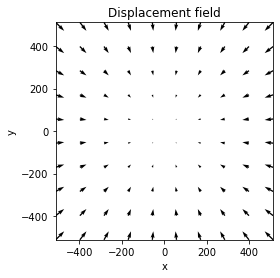

In [6]:
# Create Displacement field image
x,y = np.meshgrid(np.linspace(-xsize/2,xsize/2,10),np.linspace(-ysize/2,ysize/2,10))
vx = dt * velocityx(x,y)
vy = dt * velocityy(x,y)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.quiver(x,y,vx,vy, angles='xy', scale_units='xy', scale=1)
ax.set_aspect('equal')
plt.xlim([-xsize/2, xsize/2])
plt.ylim([-ysize/2, ysize/2])
plt.title("Displacement field")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('DirectionalField.png', dpi=300)

# Figure particles before and after
Here, we create a image of the particles before (red) and after the particles are displaced by the velocity field.

(-512.0, 512.0)

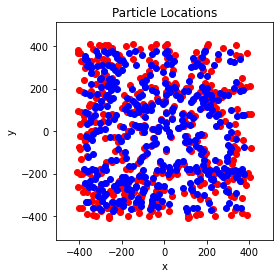

In [7]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(Particles_Pos[:,0], Particles_Pos[:,1], c='r')
plt.scatter(New_Particles_Pos[:,0], New_Particles_Pos[:,1], c='b')
plt.title("Particle Locations")
plt.xlabel("x")
plt.ylabel("y")
ax.set_aspect('equal')
plt.xlim([-xsize/2, xsize/2])
plt.ylim([-ysize/2, ysize/2])

# Create binary images before and after velocity field applied
Here, we initialize the zero arrays of size (xsize, ysize). Then, we find those pixel that are within a circle of radius "Particleradius", iterate over all particles and add the value 255 into those pixel within the circle.

In [8]:
# Import
import matplotlib.pyplot as plt
from skimage import draw
# Initialise Arrays
Binary      = np.zeros((xsize,ysize), dtype=np.int) 
New_Binary  = np.zeros((xsize,ysize), dtype=np.int) 
# Prepare index array
y, x = np.ogrid[-Particleradius: Particleradius, -Particleradius: Particleradius]
index = x**2 + y**2 <= Particleradius**2
# Add particles to array for the initial binary image
for j in range(0, NoParticles):
    Centerx = int(Particles_Pos[j,0]+xsize/2)
    Centery = int(Particles_Pos[j,1]+ysize/2)
    Binary[Centery-Particleradius:Centery+Particleradius, Centerx-Particleradius:Centerx+Particleradius][index] = 255
# Add particles to array for the initial binary image
for j in range(0, NoParticles):
    Centerx = int(New_Particles_Pos[j,0]+xsize/2)
    Centery = int(New_Particles_Pos[j,1]+ysize/2)
    New_Binary[Centery-Particleradius:Centery+Particleradius, Centerx-Particleradius:Centerx+Particleradius][index] = 255

# Gaussian blur images
Here, we Gaussian Blur the images.

In [9]:
from scipy.ndimage.filters import gaussian_filter
Image_old = gaussian_filter(Binary, sigma=Gaussianwidth)
Image_new = gaussian_filter(New_Binary, sigma=Gaussianwidth)

# Add noise on top of binary images
Here, we add White noise on the data.

In [10]:
import random
for i in range(xsize): 
    for j in range(ysize):
        Noise=random.gauss(0, Noise_std)
        Image_old[i,j] = Image_old[i,j] + Noise
        
for i in range(xsize): 
    for j in range(ysize):
        Noise=random.gauss(0, Noise_std)
        Image_new[i,j] = Image_new[i,j] + Noise

# Show binary images before and after
Output the images before and after.

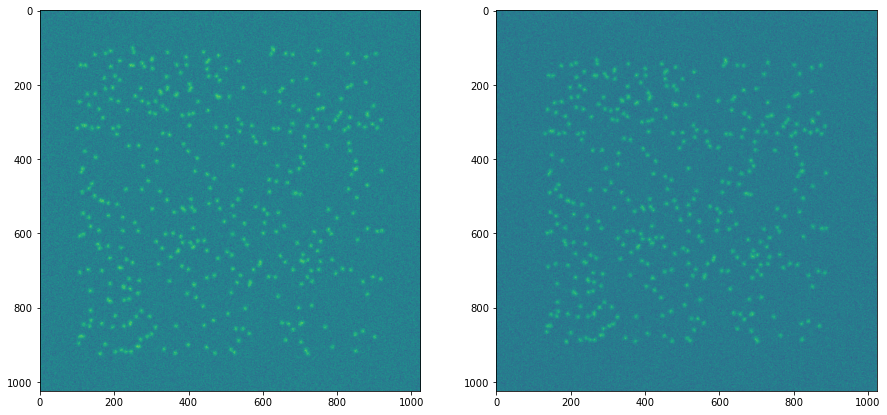

In [14]:
import matplotlib.pyplot as plt
import numpy as np
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Image_old)
axarr[1].imshow(Image_new)

# Save binary images to use them for PIV
Save the images so that they can be used by the TFM pipeline.

In [15]:
import cv2
cv2.imwrite('Image_old.tiff',Image_old.astype(int))
cv2.imwrite('Image_new.tiff',Image_new.astype(int))
cv2.imwrite('Ground_old.tiff',Binary.astype(int))
cv2.imwrite('Ground_new.tiff',New_Binary.astype(int))

True